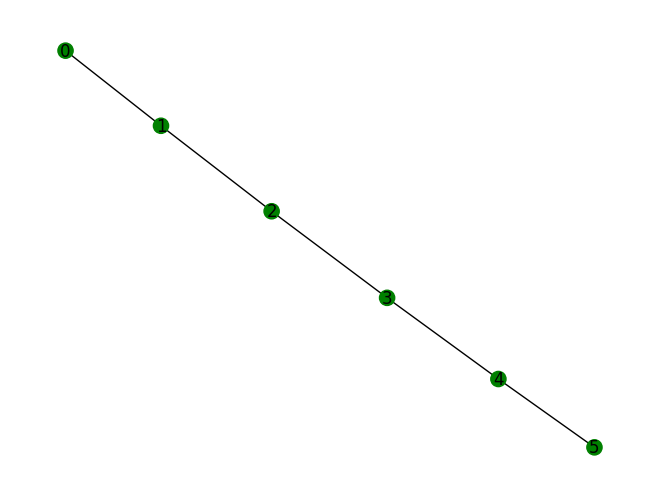

In [4]:
from disqco.circuits.cp_fraction import cp_fraction, cz_fraction
from disqco.graphs.GCP_hypergraph import QuantumCircuitHyperGraph
from qiskit import transpile
from disqco.parti.FM.FM_methods import set_initial_partitions
from disqco.circuits.QAOA import QAOA_random
from qiskit.circuit.library import QFT, QuantumVolume  
from disqco.graphs.quantum_network import QuantumNetwork, linear_coupling, grid_coupling, random_coupling

import pickle

num_qubits = 32

circuit = cp_fraction(  num_qubits=num_qubits,
                        depth=num_qubits,
                        fraction= 0.5)

circuit = QuantumVolume(num_qubits=num_qubits, depth=num_qubits)

num_qubits = circuit.num_qubits

circuit = transpile(circuit, basis_gates = ['cp', 'u'])

num_partitions = 6


qpu_sizes = [int(num_qubits/num_partitions)+1]*num_partitions

# coupling = [[i, i+1] for i in range(num_partitions-1)]

# coupling = grid_coupling(num_partitions)
coupling = linear_coupling(num_partitions)

network = QuantumNetwork(qpu_sizes, coupling)

network.draw()



In [5]:
graph = QuantumCircuitHyperGraph(circuit, group_gates = True, anti_diag = True)
assignment = set_initial_partitions(network=network, num_qubits=num_qubits, depth=graph.depth)

from disqco.parti.FM.FM_methods import get_all_configs, get_all_costs_hetero

if num_partitions <=10:

    configs = get_all_configs(num_partitions, hetero=True)

    costs, edge_tree = get_all_costs_hetero(network, configs)
else:

    costs = {}

print(costs)

Number of layers: 195
{((1, 0, 1, 1, 0, 0), (1, 0, 1, 1, 0, 0)): 0, ((1, 0, 1, 1, 0, 0), (0, 1, 1, 0, 0, 1)): 2, ((1, 0, 1, 1, 0, 0), (1, 1, 0, 0, 1, 0)): 1, ((1, 0, 1, 1, 0, 0), (1, 0, 0, 1, 1, 1)): 2, ((1, 0, 1, 1, 0, 0), (1, 0, 1, 0, 1, 1)): 2, ((1, 0, 1, 1, 0, 0), (1, 1, 0, 1, 1, 0)): 1, ((1, 0, 1, 1, 0, 0), (0, 0, 0, 1, 1, 0)): 1, ((1, 0, 1, 1, 0, 0), (0, 0, 1, 1, 0, 0)): 0, ((1, 0, 1, 1, 0, 0), (1, 1, 1, 0, 1, 1)): 2, ((1, 0, 1, 1, 0, 0), (1, 0, 0, 0, 1, 1)): 2, ((1, 0, 1, 1, 0, 0), (1, 0, 1, 1, 1, 1)): 2, ((1, 0, 1, 1, 0, 0), (0, 1, 1, 0, 0, 0)): 0, ((1, 0, 1, 1, 0, 0), (1, 0, 0, 1, 0, 1)): 2, ((1, 0, 1, 1, 0, 0), (0, 0, 1, 0, 0, 0)): 0, ((1, 0, 1, 1, 0, 0), (0, 1, 1, 1, 1, 0)): 1, ((1, 0, 1, 1, 0, 0), (1, 0, 0, 1, 1, 0)): 1, ((1, 0, 1, 1, 0, 0), (0, 1, 0, 0, 1, 1)): 2, ((1, 0, 1, 1, 0, 0), (1, 1, 1, 0, 0, 1)): 2, ((1, 0, 1, 1, 0, 0), (1, 1, 1, 0, 1, 0)): 1, ((1, 0, 1, 1, 0, 0), (0, 1, 1, 1, 0, 1)): 2, ((1, 0, 1, 1, 0, 0), (1, 1, 1, 1, 1, 1)): 2, ((1, 0, 1, 1, 0, 0), (1, 0, 0, 0

In [6]:
# from disqco.parti.FM.FM_hetero import run_FM_hetero

# final_cost, final_assignment, cost_list = run_FM_hetero(hypergraph=graph,
#                                                         initial_assignment=assignment,
#                                                         qpu_info=qpu_sizes,
#                                                         num_partitions=num_partitions,
#                                                         network=network,
#                                                         limit=num_qubits,
#                                                         costs={},
#                                                         passes=50,
#                                                         log=True)





In [7]:
from disqco.drawing.tikz_drawing import draw_graph_tikz
from disqco.drawing.mpl_drawing import draw_graph_mpl

%load_ext jupyter_tikz

# if num_qubits <= 32:
#     draw_graph_tikz(graph, assignment, qpu_sizes)
# else:
#     if num_qubits <= 64:
#         draw_graph_mpl(graph, assignment, qpu_sizes)

In [8]:
# print("Final cost: ", final_cost)
import qiskit
qiskit.__version__

'1.2.4'

In [9]:
from disqco.parti.FM.multilevel_FM import MLFM_recursive_hetero

print(qpu_sizes)

final_assignment_list, final_cost_list, _ = MLFM_recursive_hetero(graph,
                                                                    assignment,
                                                                    qpu_sizes,
                                                                    limit=num_qubits,
                                                                    network=network,
                                                                    log=True,
                                                                    stochastic=True,
                                                                    costs=costs, 
                                                                    level_limit=None)





[6, 6, 6, 6, 6, 6]
Time to coarsen graph: 0.17 seconds
Initial cost: 2728
All passes complete.
Final cost: 2430
Best cost at level 0: 2430
Initial cost: 2430
All passes complete.
Final cost: 2270
Best cost at level 1: 2270
Initial cost: 2270
All passes complete.
Final cost: 2272
Best cost at level 2: 2270
Initial cost: 2270
All passes complete.
Final cost: 2115
Best cost at level 3: 2115
Initial cost: 2115
All passes complete.
Final cost: 1877
Best cost at level 4: 1877
Initial cost: 1877
All passes complete.
Final cost: 1548
Best cost at level 5: 1548
Initial cost: 1548
All passes complete.
Final cost: 1399
Best cost at level 6: 1399
Initial cost: 1399
All passes complete.
Final cost: 1212
Best cost at level 7: 1212
Initial cost: 1212
All passes complete.
Final cost: 1212
Best cost at level 8: 1212


In [10]:

import numpy as np

final_assignment = final_assignment_list[np.argmin(final_cost_list)]

counts = []

for layer in final_assignment:
    counts.append(np.bincount(layer))
    print(layer)

print(counts)
# if num_qubits <= 32:
#     fig = draw_graph_tikz(graph, final_assignment, qpu_sizes)
#     display(fig)
# else:
#      draw_graph_mpl(graph, final_assignment, qpu_sizes)

[3 1 2 5 5 0 2 1 3 4 5 2 3 1 4 2 2 3 3 0 5 5 4 2 5 0 1 1 3 4 1 0]
[3 1 2 5 5 0 2 1 3 4 5 2 3 1 4 2 2 3 3 0 5 5 4 2 5 0 1 1 3 4 1 0]
[3 1 2 5 5 0 2 1 3 4 5 2 3 1 4 2 2 3 3 0 5 5 4 2 5 0 1 1 3 4 1 0]
[3 1 2 5 5 0 2 1 3 4 5 2 3 1 4 2 2 3 3 0 5 5 4 2 5 0 1 1 3 4 1 0]
[3 1 2 5 5 0 2 1 3 4 5 2 3 1 4 2 2 3 3 0 5 5 4 2 5 0 1 1 3 4 1 0]
[3 1 2 5 5 0 1 1 3 4 5 2 3 1 4 2 2 3 3 0 5 5 4 2 5 0 2 1 3 4 1 0]
[3 1 2 5 5 0 1 1 3 4 5 2 3 1 4 2 2 3 3 0 5 5 4 2 5 0 2 1 3 4 1 0]
[3 1 2 5 5 0 1 2 3 4 5 0 3 1 4 2 2 3 3 0 4 5 4 2 5 1 2 4 3 4 5 0]
[3 1 2 5 5 0 1 2 3 4 5 0 3 1 4 2 2 3 3 0 4 5 4 2 5 1 2 4 3 4 5 0]
[3 1 2 5 5 0 1 3 4 4 5 0 3 1 4 2 2 3 3 1 4 5 4 2 5 1 2 3 2 4 5 1]
[3 1 2 5 5 0 1 3 4 4 5 0 3 1 4 2 2 3 3 1 4 5 4 2 5 1 2 3 2 4 5 1]
[3 1 2 5 5 0 1 3 4 4 5 0 3 1 4 2 2 3 3 1 4 5 4 2 5 1 2 3 2 4 5 1]
[3 1 2 5 5 0 1 3 4 4 5 0 3 1 4 2 2 3 3 1 4 5 4 2 5 1 2 3 2 4 5 1]
[3 1 4 4 5 0 2 3 3 4 5 2 3 0 1 2 2 5 3 1 4 1 5 2 5 1 3 1 4 4 5 2]
[3 1 4 4 5 0 2 3 3 4 5 2 3 0 1 2 2 5 3 1 4 1 5 2 5 1 3 1 4 4 5 2]
[3 1 4 4 5

In [11]:
from disqco.parti.FM.multilevel_FM import MLFM_recursive

list_of_assignments, list_of_costs, _ = MLFM_recursive(
    graph,
    assignment,
    qpu_sizes,
    limit='qubit',
    log=True)

from disqco.graphs.hypergraph_methods import calculate_full_cost_hetero
import numpy as np

best_assignment = list_of_assignments[np.argmin(list_of_costs)]
print("best assignment", best_assignment)
cost_hetero = calculate_full_cost_hetero(graph, best_assignment, num_partitions, costs, network)

print(cost_hetero)

Initial cost: 1289
All passes complete.
Final cost: 1102
Best cost at level 0: 1102
Initial cost: 1102
All passes complete.
Final cost: 1038
Best cost at level 1: 1038
Initial cost: 1038
All passes complete.
Final cost: 1021
Best cost at level 2: 1021
Initial cost: 1021
All passes complete.
Final cost: 884
Best cost at level 3: 884
Initial cost: 884
All passes complete.
Final cost: 748
Best cost at level 4: 748
Initial cost: 748
All passes complete.
Final cost: 636
Best cost at level 5: 636
Initial cost: 636
All passes complete.
Final cost: 574
Best cost at level 6: 574
Initial cost: 574
All passes complete.
Final cost: 433
Best cost at level 7: 433
Initial cost: 433
All passes complete.
Final cost: 433
Best cost at level 8: 433
best assignment [[1 2 5 ... 4 4 0]
 [1 2 5 ... 4 4 0]
 [1 2 5 ... 4 4 0]
 ...
 [1 3 1 ... 4 4 4]
 [1 3 1 ... 4 4 4]
 [1 3 1 ... 4 4 4]]
1031


In [12]:
from disqco.utils.qiskit_to_op_list import circuit_to_gate_layers
layers = circuit_to_gate_layers(circuit)

for layer in layers:
    for gate in layer:
        print(gate)
        # print(gate.qargs)
        # print(gate.op.name)
        # print(gate.op.params)
        # print(gate.op.to_dict())
        # print(gate.op.to_matrix())
        # print(gate.op.to_instruction())
        # print(gate.op.to_gate())
        # print(gate.op.to_circuit())

Number of layers: 195
['u', [0], ['q'], [1.279411315080094, 1.1713531074906127, -2.8380089427490427]]
['u', [1], ['q'], [0.3254262142372336, -3.0567240878860185, -2.8691570943778775]]
['u', [2], ['q'], [2.4633708191518804, 1.4866499205751715, 1.8570038972604346]]
['u', [3], ['q'], [0.8154061280034925, -1.1944289018689274, 0.4091638211946993]]
['u', [4], ['q'], [1.8399119613099277, 1.4240372166834199, 1.3844810630133582]]
['u', [5], ['q'], [1.1251796069992033, -0.8941805842765254, -1.1413402778200634]]
['u', [6], ['q'], [0.48363587859657603, 2.5457924172762922, 0.58455801685857]]
['u', [7], ['q'], [0.8279476060631882, 0.9591976409687746, 0.4754197332976351]]
['u', [8], ['q'], [2.6231076421546438, 0.18870322949727614, -1.8362542280545602]]
['u', [9], ['q'], [2.8743602934962436, 0.47175272380969346, -0.36053174581439906]]
['u', [10], ['q'], [1.5182016743496196, 2.8543871192490267, 2.093396605331833]]
['u', [11], ['q'], [0.47789940160028666, -0.06889065115925685, -0.5278799026980838]]
['u'